MainProcess


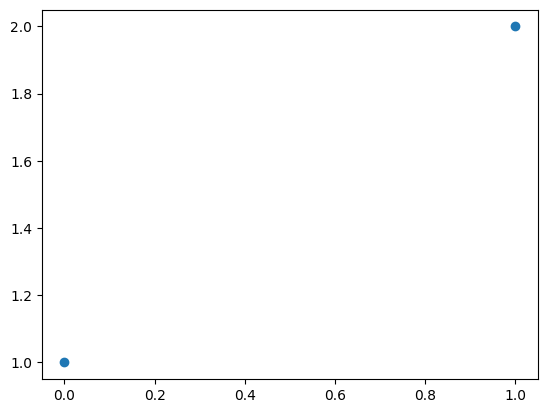

In [1]:
import sys
sys.path.append('d:/flagellar/code/core')
sys.path.append('/flagellar/code/core')
sys.path.append('/kaggle/input/my-flg-library/')
import flg_support as fls
import importlib
import numpy as np
import flg_diagnostics
import flg_numerics
import matplotlib.pyplot as plt
import glob
import copy
import flg_preprocess
import os
import flg_model
fls.profiling=False
plt.scatter([0,1],[1,2])

In [2]:
files = glob.glob(fls.result_dir + '/many_full_res/Baseline_1004_*')
assert len(files)==1
loaded_data = fls.dill_load(files[0])
test_data = loaded_data.test_data
print(loaded_data.modifier_values)

{'seed': 1004, 'n_ensemble': 3, 'n_epochs': 30, 'use_best_epoch': False, 'extra_data': False, 'trust_neg': 1, 'model_name': 'yolov8m'}


In [3]:
highest_false_score = []
real_score = []
data_list = []
for i_type in range(10):
    base_model = copy.deepcopy(loaded_data.trained_model)
    base_model.step1Labels.n_ensemble=1
    base_model.step1Labels.trained_model = base_model.step1Labels.trained_model[0:1]
    base_model.step1Labels.concentration = 2
    model = base_model
    #model.step1Labels.n_epochs = 2
    #m.step2Motors.distance_threshold = 10.
    if i_type == 0:
        # baseline
        pass     
    elif i_type==1:
        # other seed
        model.step1Labels.trained_model = loaded_data.trained_model.step1Labels.trained_model[1:2]
    elif i_type==2:
        model.step1Labels.preprocessor.voxel_scale = 0.9
    elif i_type==3:
        model.step1Labels.preprocessor.voxel_scale = 0.8
    elif i_type==4:
        model.step1Labels.preprocessor.blur_xy *= 0.8
    elif i_type==5:
        model.step1Labels.preprocessor.blur_xy *= 1.2   
    elif i_type==6:
        model.step1Labels.preprocessor.clip_value = 2.5
    elif i_type==7:
        model.step1Labels.preprocessor.clip_value = 3.5
    elif i_type==8:
        model.step1Labels.preprocessor.apply_transpose = True
    elif i_type==9:
        model.step1Labels.preprocessor.apply_flipud = True
    model.step1Labels.relative_confidence_threshold = 0.01
    data_file = fls.temp_dir + 'data_tta2_' + str(i_type) + '.pickle'    
    if not os.path.isfile(data_file):        
        inferred_data = model.infer(test_data)
        for d in inferred_data:
            d.labels_unfiltered = d.labels_unfiltered2 
        fls.mark_tf_pn(inferred_data, test_data)
        fls.dill_save(data_file, inferred_data)        
    inferred_data = fls.dill_load(data_file)       
    data_list.append(inferred_data)
    this_highest_false_score = []
    this_real_score = []
    for i,r in zip(inferred_data, test_data):
        false_positives = i.labels_unfiltered[i.labels_unfiltered['tf_pn']==1.]
        if len(false_positives)>0:
            this_highest_false_score.append(np.max(false_positives['confidence']))
        else:
            this_highest_false_score.append(0)
        if len(r.labels)>0:
            true_positives = i.labels_unfiltered[i.labels_unfiltered['tf_pn']==0.]
            if len(true_positives)>0:
                this_real_score.append(np.max(true_positives['confidence']))
            else:
                this_real_score.append(0)
    highest_false_score.append(this_highest_false_score)
    real_score.append(this_real_score)


In [4]:
for d in data_list:
    n_corr=0
    n_total=0
    for i,r in zip(d,test_data):
        if len(r.labels)>0:# and 'tom' in r.name:
            n_total+=1
            ind = np.argmax(i.labels_unfiltered['confidence'])
            if (i.labels_unfiltered['tf_pn'].tolist()[ind])==0.:
                n_corr += 1
    print(n_corr/n_total)
    #print(i.labels_unfiltered)

0.905
0.94
0.925
0.91
0.92
0.915
0.905
0.915
0.845
0.93


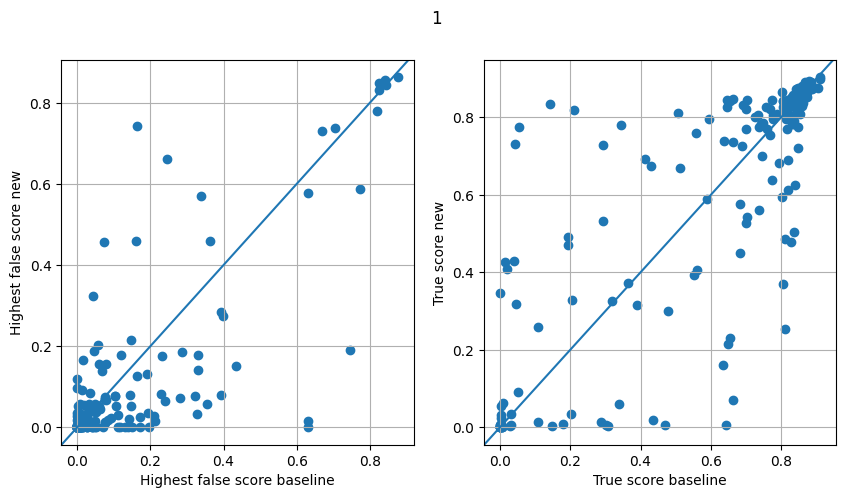

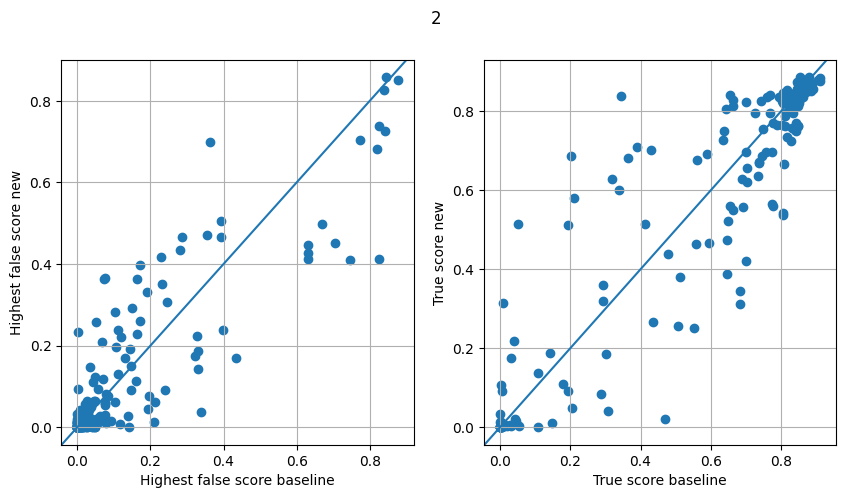

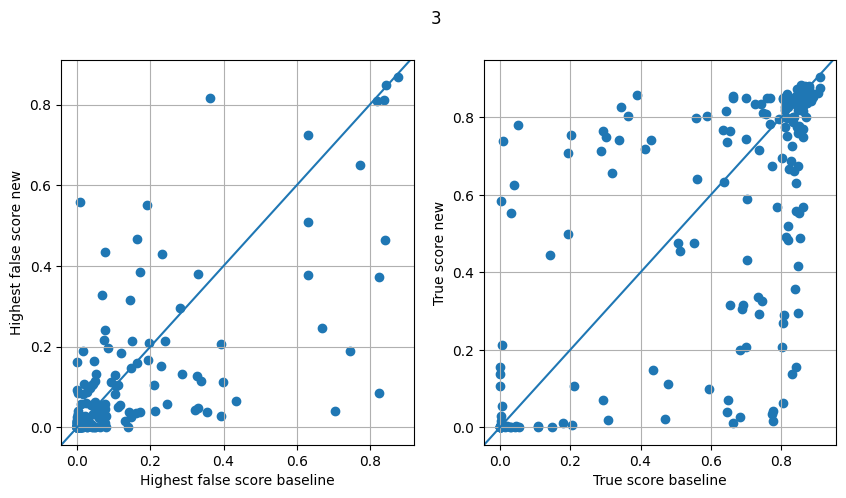

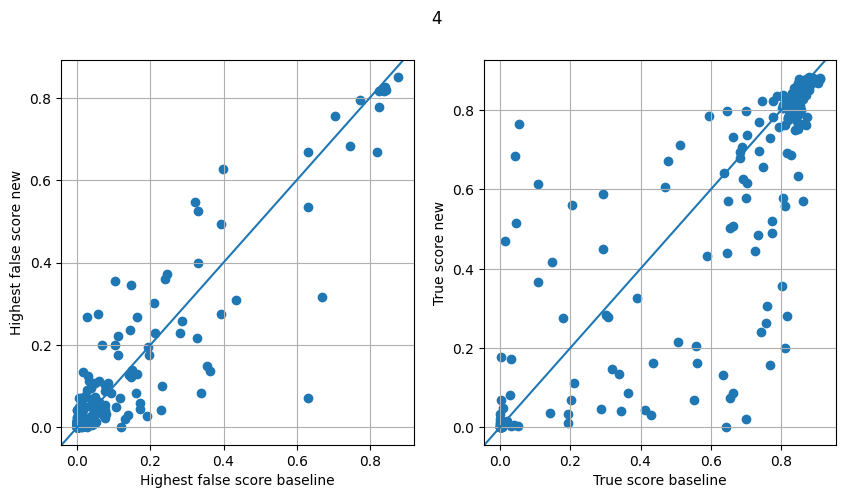

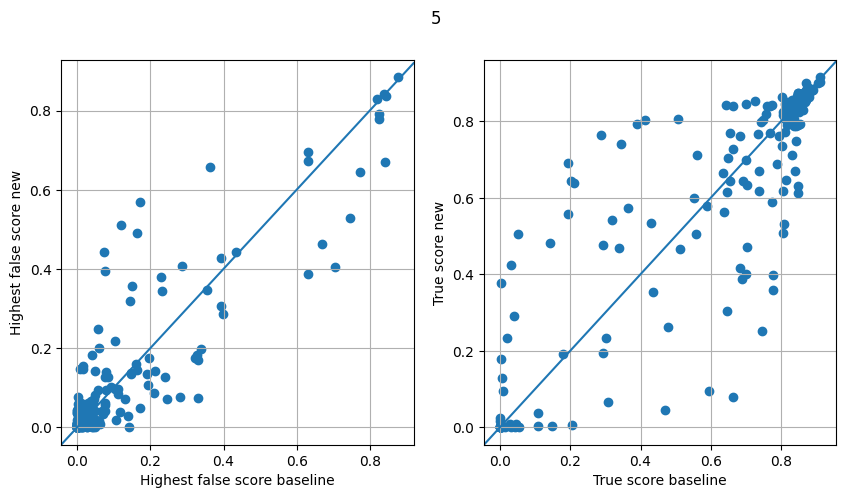

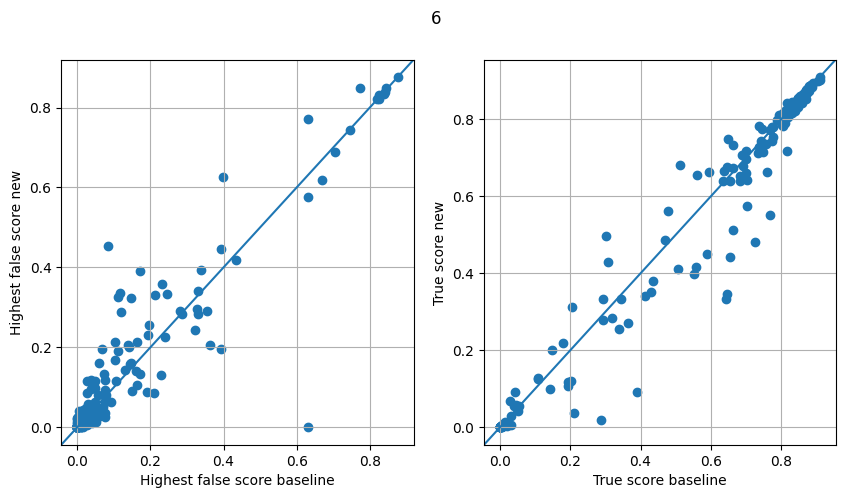

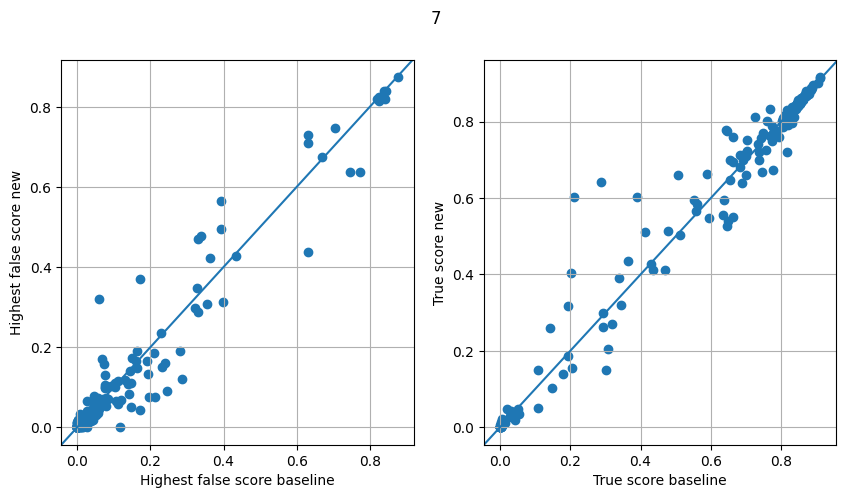

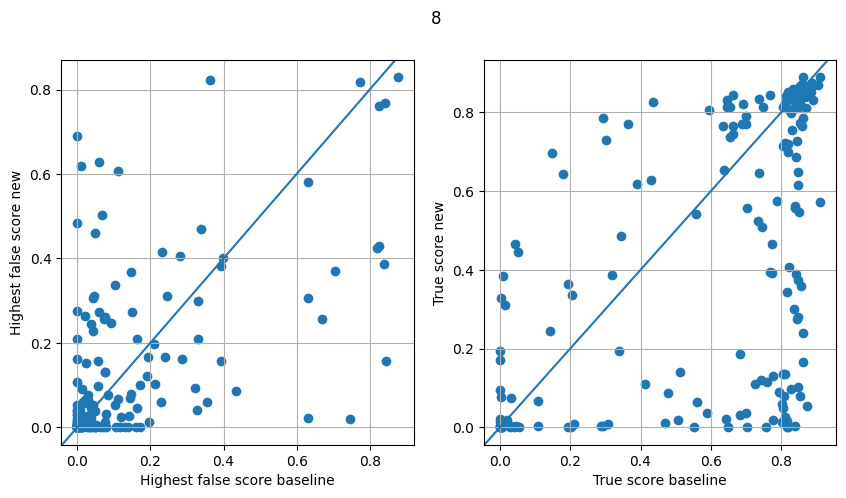

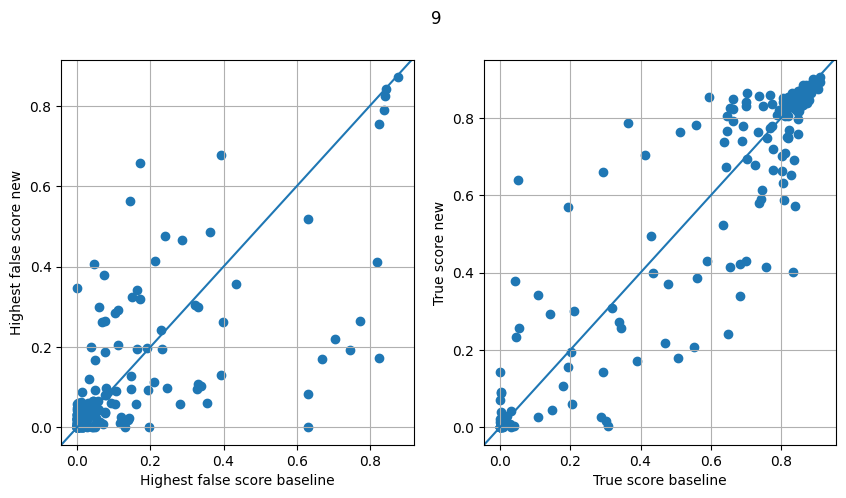

In [5]:
i_baseline = 0
for i_new in np.arange(1,len(highest_false_score)):
    _,ax=plt.subplots(1,2,figsize=(10,5))
    plt.sca(ax[0])
    plt.scatter(highest_false_score[i_baseline], highest_false_score[i_new])
    plt.xlabel('Highest false score baseline')
    plt.ylabel('Highest false score new')
    plt.grid(True)
    plt.axline((0,0),slope=1)
    plt.sca(ax[1])
    plt.scatter(real_score[i_baseline], real_score[i_new])
    plt.xlabel('True score baseline')
    plt.ylabel('True score new')
    plt.grid(True)
    plt.axline((0,0),slope=1)
    plt.suptitle(str(i_new))

In [6]:
xx=(np.argwhere(np.logical_and(np.array(real_score[0])>0.8, np.array(real_score[8])<0.05))).flatten()
xx

array([ 10,  32,  68, 105, 142, 173, 190], dtype=int64)

In [7]:
cur_id = 0
for ii in range(len(test_data)):
    if len(test_data[ii].labels)>0:     
        if cur_id in xx:
            print(test_data[ii].name,ii,real_score[i_baseline][cur_id],real_score[i_new][cur_id])
        cur_id+=1

mba2011-11-23-33 40 0.81640625 0.751953125
mba2012-03-09-34 62 0.806640625 0.8408203125
aba2015-06-04-17 98 0.8115234375 0.80419921875
ycw2013-08-20-43 135 0.81640625 0.83642578125
mba2011-08-10-30 172 0.83984375 0.57373046875
mba2011-07-18-15 203 0.82080078125 0.83642578125
aba2014-10-29-20 220 0.8017578125 0.66357421875


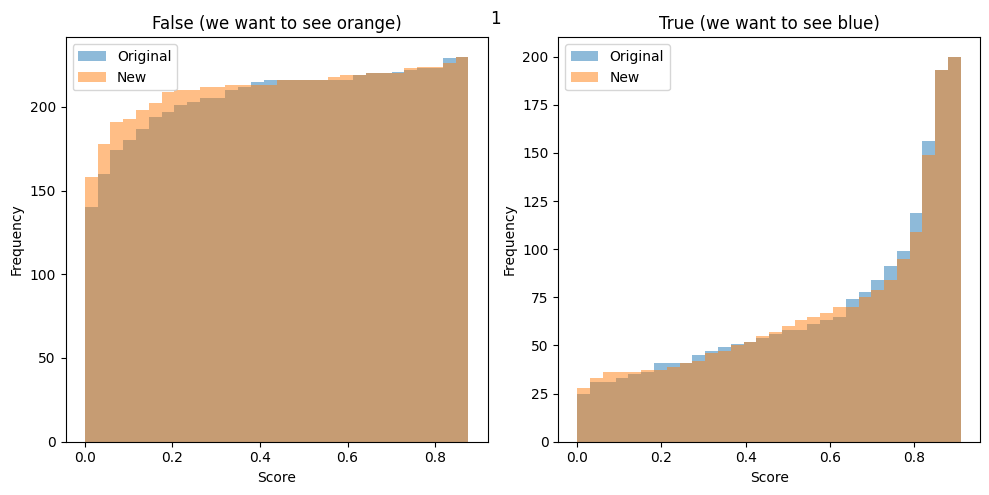

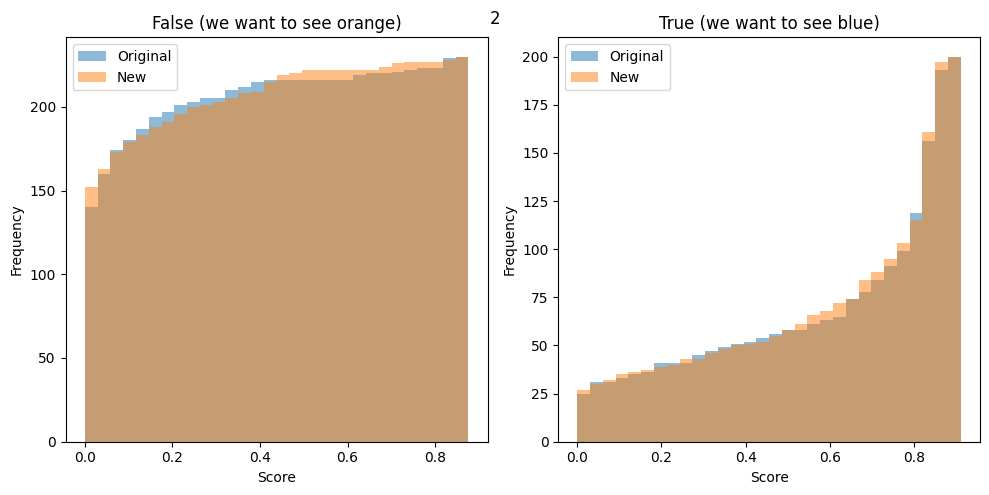

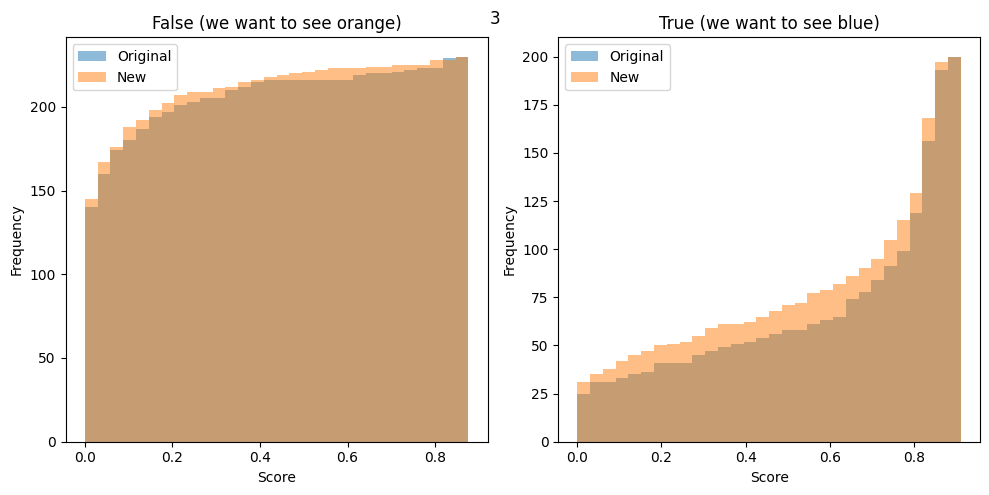

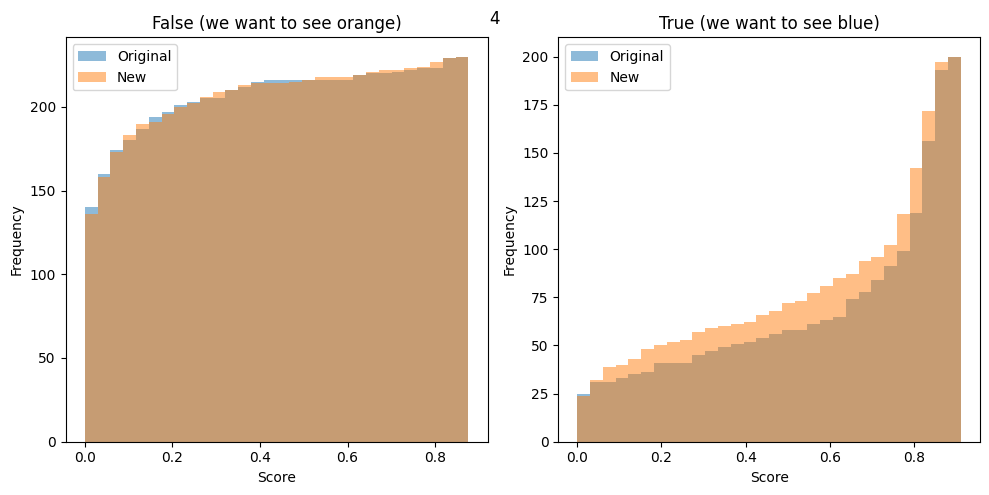

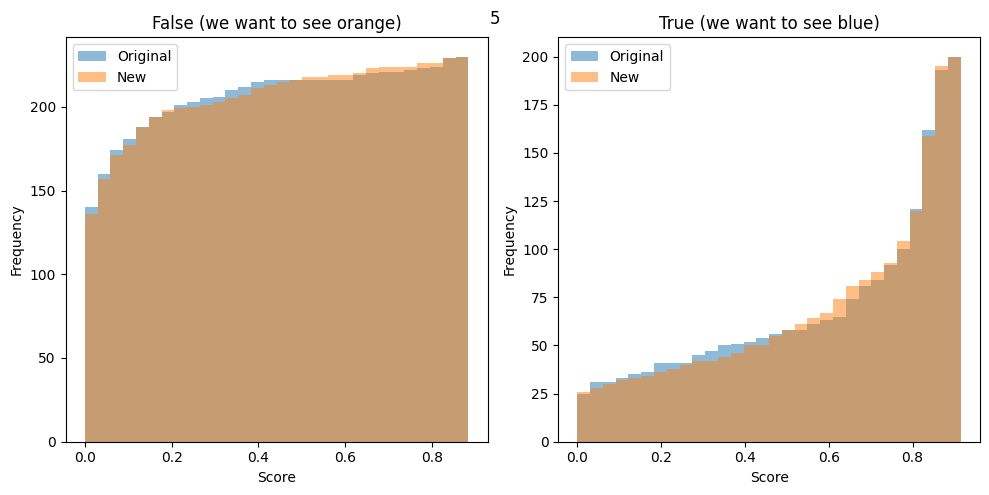

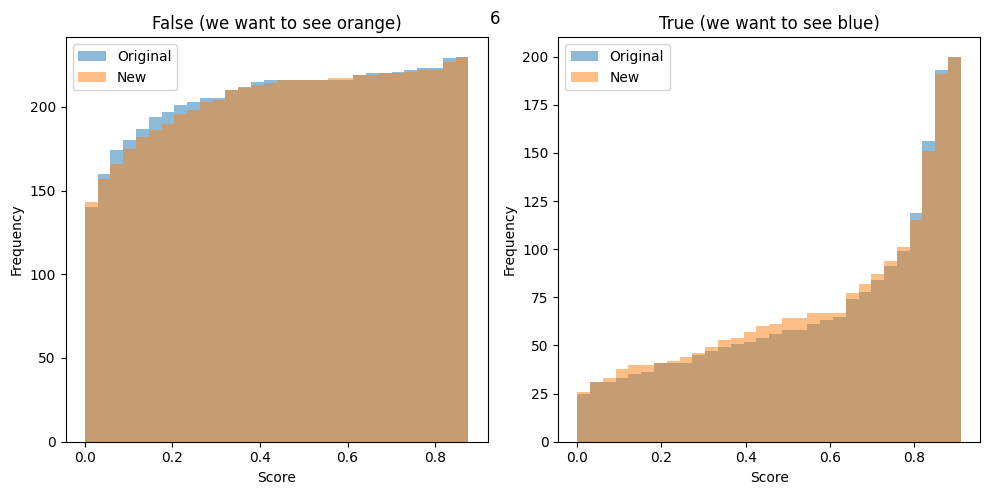

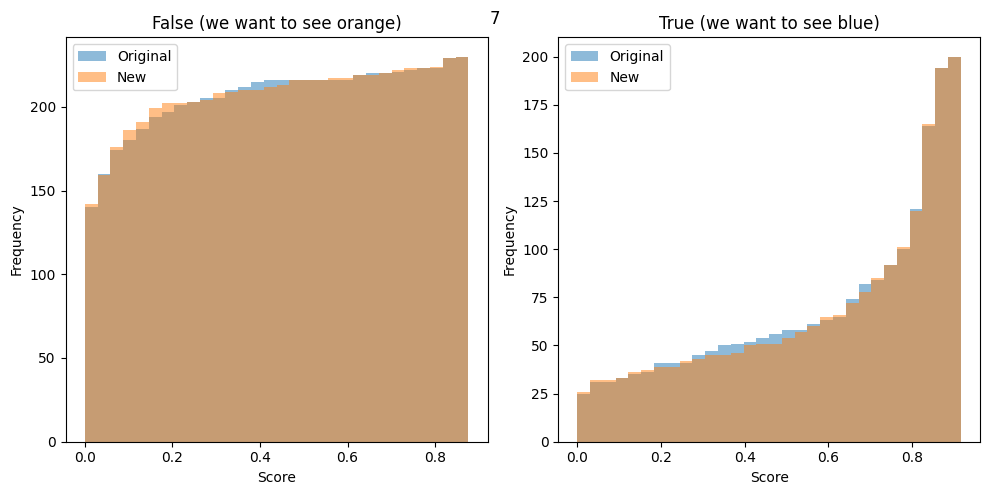

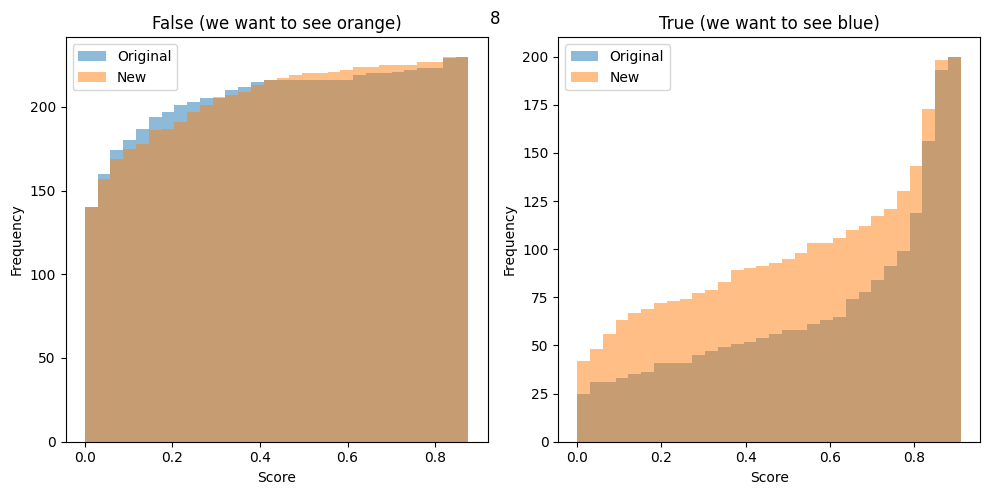

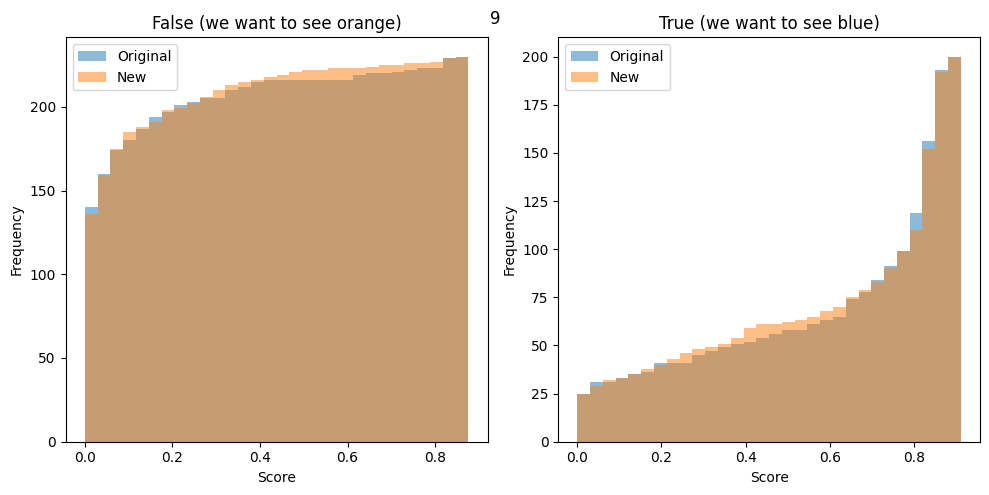

In [8]:
import numpy as np
import matplotlib.pyplot as plt

i_baseline = 0
for i_new in np.arange(1,len(highest_false_score)):
    # flatten the two arrays into one to get global bin edges
    all_scores = np.concatenate([highest_false_score[i_baseline], highest_false_score[i_new]])
    # choose number of bins (e.g. 30) or compute automatically
    bins = np.histogram_bin_edges(all_scores, bins=30)
    
    _,ax=plt.subplots(1,2,figsize=(10, 5))
    plt.sca(ax[0])
    plt.hist(highest_false_score[i_baseline], bins=bins, cumulative=True, alpha=0.5, label='Original')
    plt.hist(highest_false_score[i_new], bins=bins, cumulative=True, alpha=0.5, label='New')
    plt.xlabel('Score')
    plt.ylabel('Frequency')
    plt.title('False (we want to see orange)')
    plt.legend()
    plt.tight_layout()
    
    # flatten the two arrays into one to get global bin edges
    all_scores = np.concatenate([real_score[i_baseline], real_score[i_new]])
    # choose number of bins (e.g. 30) or compute automatically
    bins = np.histogram_bin_edges(all_scores, bins=30)

    plt.sca(ax[1])
    plt.hist(real_score[i_baseline], bins=bins, cumulative=True, alpha=0.5, label='Original')
    plt.hist(real_score[i_new], bins=bins, cumulative=True, alpha=0.5, label='New')
    plt.xlabel('Score')
    plt.ylabel('Frequency')
    plt.title('True (we want to see blue)')
    plt.legend()
    plt.tight_layout()

    plt.suptitle(str(i_new))

In [9]:
import numpy as np
import matplotlib.pyplot as plt



In [10]:
def visualize_fp_fn(data, threshold_fp, threshold_fn):

    all_data = fls.load_all_train_data() + fls.load_all_extra_data()
    def visualize_slice(name, z,y,x, color, title_str):
        for d in all_data:
            if d.name == name:
                break
        else:
            raise 'Not found'
        d = copy.deepcopy(d)
        prep = flg_preprocess.Preprocessor2()
        prep.load_and_preprocess(d, desired_original_slices = [z])

        plt.figure()
        plt.imshow(d.data[0,:,:], cmap='bone')
        plt.colorbar()
        plt.title(title_str + ': ' + name + ', ' + str(z))

        plt.scatter([x*d.resize_factor], [y*d.resize_factor], alpha=0.3, color=color, s=200)
    
    for d in data:  
        if not 'tom' in d.name:
            continue
        lab = copy.deepcopy(d.labels_unfiltered).reset_index()

        # false negatives
        if not np.any(np.logical_and(lab['tf_pn']==0., lab['confidence']>threshold_fn)):
            for r in all_data:
                if r.name == d.name:
                    break
            else:
                raise 'Not found'
            if len(r.labels)>0:
                attempts = lab[lab['tf_pn']==0.]
                if len(attempts)>0:
                    thresh = np.max(attempts['confidence'])
                else:
                    thresh = 0.
                visualize_slice(d.name, np.round(r.labels['z'][0]).astype(int),r.labels['y'][0],r.labels['x'][0], 'blue', 'False negative: '+str(thresh))

        # false positives
        slices_done = []
        for i_row in range(len(lab)):
            if lab['tf_pn'][i_row]==1. and lab['confidence'][i_row]>threshold_fp and lab['z'][i_row] not in slices_done:
                #print('fp', d.name, lab['z'][i_row], lab['confidence'][i_row])
                visualize_slice(d.name, lab['z'][i_row],lab['y'][i_row],lab['x'][i_row], 'red', 'False positive ' + str(lab['confidence'][i_row]))
                for ii in np.arange(lab['z'][i_row]-10, lab['z'][i_row]+11):
                    slices_done.append(ii)
#visualize_fp_fn(data_list[i_new], 0.8, 0.8)

C:\Users\jeroe\anaconda3\envs\jupyterlab-debugger2\lib\site-packages\cupyx\jit\_interface.py:173: FutureWarning: cupyx.jit.rawkernel is experimental. The interface can change in the future.
  cupy._util.experimental('cupyx.jit.rawkernel')


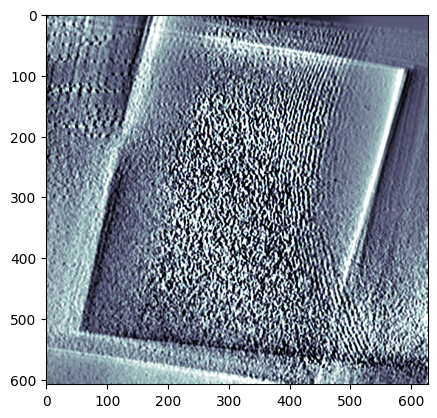

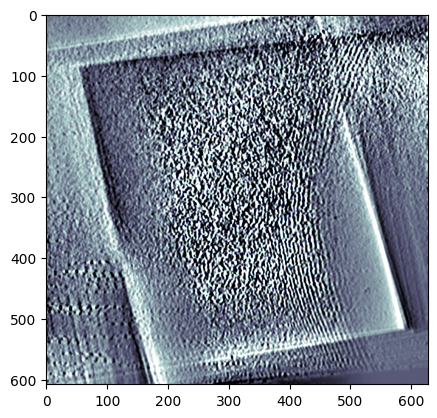

In [11]:
for transpose in [False,True]:
    prep = model.step1Labels.preprocessor
    prep.apply_flipud = transpose
    dat = copy.deepcopy(test_data[0])
    prep.load_and_preprocess(dat)
    plt.figure()
    plt.imshow(dat.data[dat.data.shape[0]//2,...], cmap='bone')


In [12]:
dat.data_shape

(800, 928, 960)

In [13]:
def visualize_slice(data, z_list):
    # preprocessor = copy.deepcopy(models[0].trained_model.step1Labels.preprocessor)
    # #preprocessor.blur_z = 5
    # preprocessor.blur_xy = 1
    # preprocessor.scale_moving_average = True
    # preprocessor.scale_also_moving_std = True
    # #preprocessor.moving_ratio = 0.
    # data = copy.deepcopy(data)
    # preprocessor.load_and_preprocess(data, desired_original_slices = z_list)
    # dat = []
    # for mm in range(1):
    #     m = copy.deepcopy(models[mm].trained_model)
    #     m.step1Labels.preprocessor = preprocessor
    #     m.step1Labels.relative_confidence_threshold = 0.001
    #     m.step2Motors.distance_threshold = 10.
    #     m.run_in_parallel = False
    #     dat.append (m.infer([data])[0])
    m = base_model
    #m.step1Labels.preprocessor.blur_z = 60
    #m.step1Labels.img_size //= 4
    m.step1Labels.relative_confidence_threshold = 0.01
    m.step1Labels.preprocessor.apply_transpose = True
    m.step1Labels.concentration = 2
    #m.step1Labels.prevent_ultralytics_resize = True
    m.run_in_parallel = False
    dat = []
    dat.append (m.infer([data])[0])
    data = copy.deepcopy(data)
    m.preprocessor.load_and_preprocess(data, desired_original_slices = z_list)
    for i_z,z in enumerate(data.slices_present):
    #     if data.slices_present[i_z]==z:
    #         break
    # else:
    #     raise 'stop'
        plt.figure()
        plt.imshow(data.data[i_z,:,:], cmap='bone')
        plt.colorbar()
        plt.title(data.name + ', ' + str(z))
        for d in dat:
            print(d.labels)
            print(d.labels_unfiltered)
            print(d.labels_unfiltered2)
            assert d.name == data.name
            to_plot = d.labels_unfiltered2
        
            to_plot = to_plot[to_plot['z']==z]
            print('z: ', z)
            print(to_plot)
    
            plt.scatter(data.resize_factor*to_plot['x'], data.resize_factor*to_plot['y'])
#             #print(dat)    
    # for mm in range(1):
    #     # m = copy.deepcopy(models[mm].trained_model)
    #     # m.step1Labels.relative_confidence_threshold = 0.01
    #     # m.step2Motors.distance_threshold = 10.
    #     # m.run_in_parallel = False
    #     # dat = m.infer([data])
    #     dat = models[mm].inferred_test_data
    #     for d in dat:
    #         if d.name == data.name:
    #             to_plot = d.labels_unfiltered2
            
    #             to_plot = to_plot[to_plot['z']==z]
    #             print(to_plot)
        
    #             plt.scatter(to_plot['x'], to_plot['y'])
    #             #print(dat)    

   index    z    y    x  confidence     value
0      0  132  186  180    0.839844  0.839844
Clearing cupy
Model summary (fused): 92 layers, 25,840,339 parameters, 0 gradients, 78.7 GFLOPs
Processing tomogram mba2011-08-10-30 (1/1)
Processing 8 out of 17 slices (CONCENTRATION=2)
FINAL
     z    y    x  confidence
0  130  185  181    0.042877
1  130  195  176    0.001846
2  118  412  279    0.001069

Clearing pytorch
   index    z    y    x  confidence     value
0      0  130  185  181    0.042877  0.042877
     z    y    x  confidence
0  130  185  181    0.042877
1  130  195  176    0.001846
2  118  412  279    0.001069
       z    y    x  confidence  i_model
86   118  412  279    0.001069        0
102  121  410  279    0.000525        0
134  123  409  279    0.000507        0
174  125  186  182    0.003248        0
177  127  185  181    0.030106        0
178  127  195  177    0.001192        0
179  130  185  181    0.042877        0
180  130  195  176    0.001846        0
181  132  185

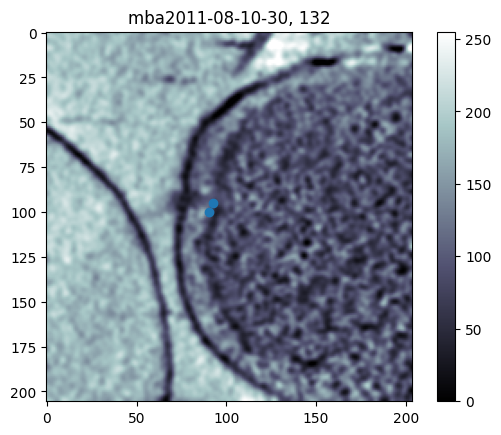

In [14]:
import flg_yolo2
importlib.reload(flg_yolo2)
for ind in [172]:
    dat= data_list[0][ind]
    print(dat.labels)
    if len(dat.labels)>0:
        visualize_slice(dat, [dat.labels['z'][0]])
        #visualize_slice(dat, [203])

In [15]:
dat.labels

,index,z,y,x,confidence,value
0,0,132,186,180,0.839844,0.839844


In [16]:
data_list[8][32].name

'mba2012-01-13-11'

In [17]:
data_list[-1][31].data_shape

(300, 959, 928)

In [18]:
959-166

793